In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import math
import datetime

from predictions import ColumnTransform

# load data

In [2]:
trains=pd.read_csv("trains/trains.csv",
                   usecols=["train_id","nr_of_stations","origin_station_code", "scheduled_departure",
                            "actual_departure", "destination_station_code","scheduled_arrival",
                            "actual_arrival","delay"],
                   parse_dates=["scheduled_departure","actual_departure",
                                "scheduled_arrival","actual_arrival"],
                  infer_datetime_format=True,
                  dtype={"train_id":np.character,
                          "origin_station_code":np.character,
                          "destination_station_code":np.character,
                          "delay":np.float}
                  )

In [3]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905628 entries, 0 to 905627
Data columns (total 9 columns):
train_id                    905628 non-null object
nr_of_stations              905628 non-null int64
origin_station_code         905628 non-null object
scheduled_departure         905628 non-null object
actual_departure            905628 non-null object
destination_station_code    905628 non-null object
scheduled_arrival           905628 non-null object
actual_arrival              905628 non-null object
delay                       875169 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 62.2+ MB


# gather the fields we want to use

In [4]:
train_data=trains[["train_id","delay","nr_of_stations"]].copy()

In [5]:
q=trains["scheduled_departure"].fillna(value=trains["actual_departure"])

train_data["dep_timestamp"]=(q.apply(lambda x:x.timestamp() if not pd.isna(x) and x!="NaT" else np.nan)).astype("Int64")

train_data["weekday"]=(q.apply(lambda x:x.weekday() if not pd.isna(x) and x!="NaT" else np.nan)).astype("Int64")

train_data["season"]=(q.apply(lambda d:math.cos(2*math.pi*(d.timetuple().tm_yday)/(365+int(d.year%4==0)))
                              if not pd.isna(d) and d!="NaT" else np.nan))

train_data["arr_timestamp"]=(trains["scheduled_arrival"].fillna(value=trains["actual_arrival"])
                             .apply(lambda x:x.timestamp() if not pd.isna(x) and x!="NaT" else np.nan))

In [6]:
len(train_data)

905628

In [7]:
train_data=train_data.dropna()

In [8]:
len(train_data)

870757

In [9]:
train_data["arr_timestamp"]=train_data["arr_timestamp"].astype("int64")
train_data["dep_timestamp"]=train_data["dep_timestamp"].astype("int64")
train_data["weekday"]=train_data["weekday"].astype("int64")
train_data["delay"]=train_data["delay"].astype("int64")

In [10]:
train_data["duration"]=train_data["arr_timestamp"]-train_data["dep_timestamp"]

_=train_data.pop("arr_timestamp")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870757 entries, 0 to 905627
Data columns (total 7 columns):
train_id          870757 non-null object
delay             870757 non-null int64
nr_of_stations    870757 non-null int64
dep_timestamp     870757 non-null int64
weekday           870757 non-null int64
season            870757 non-null float64
duration          870757 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 53.1+ MB


# Only keep data of trains with at least 3000 valid entries

In [11]:
count_train_id=train_data["train_id"].value_counts()

more_data_trains=count_train_id[count_train_id>3000].index

train_data_red=train_data[train_data["train_id"].isin(more_data_trains)].copy()

len(train_data_red)

349282

# We will use pre 2016 data to predict 2016 and pre 2017 data to predict 2017

In [12]:
train_data_2016=train_data_red[
    (datetime.datetime(2016,1,1).timestamp()<=train_data_red["dep_timestamp"])&
    (datetime.datetime(2017,1,1).timestamp()>train_data_red["dep_timestamp"])
]

In [13]:
len(train_data_2016)

34328

In [14]:
train_data_2017=train_data_red[
    (datetime.datetime(2017,1,1).timestamp()<=train_data_red["dep_timestamp"])&
    (datetime.datetime(2018,1,1).timestamp()>train_data_red["dep_timestamp"])
]

In [15]:
len(train_data_2017)

34383

# To train, we cut off 5% on either side, to get rid of outliers

In [16]:
min_delay=train_data_red["delay"].quantile(.05)
min_delay

-33.0

In [17]:
max_delay=train_data_red["delay"].quantile(.95)
max_delay

125.0

In [18]:
train_data_no_outliers=train_data_red[(min_delay<train_data_red["delay"])&(train_data_red["delay"]<max_delay)]

In [19]:
len(train_data_no_outliers)

313677

# Distribution of delay (log-scale)

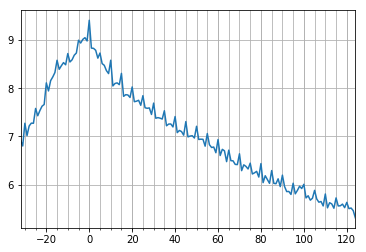

In [20]:
import matplotlib.ticker as ticker
plt.figure()
ax = plt.axes()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
np.log(train_data_no_outliers["delay"].value_counts().sort_index()).plot()
plt.grid(True,which="both")

# Preparing the training data

In [21]:
train_data_n_o_pre_2016=train_data_no_outliers[train_data_no_outliers["dep_timestamp"]<datetime.datetime(2016,1,1).timestamp()]

In [22]:
train_data_n_o_pre_2017=train_data_no_outliers[train_data_no_outliers["dep_timestamp"]<datetime.datetime(2017,1,1).timestamp()]

# Train the models

In [23]:
ct_pre_2016=ColumnTransform(train_data_n_o_pre_2016,label="delay")
td_pre_2016_tf=ct_pre_2016.transform(train_data_n_o_pre_2016)
td_pre_2016_label=td_pre_2016_tf.pop("delay")
xgb_pre_2016=xgb.DMatrix(td_pre_2016_tf,label=td_pre_2016_label)

param = {'max_depth': 4, 'eta': 0.1, "subsample":0.7,"verbosity":0}
bst_2016=xgb.train(param,xgb_pre_2016,num_boost_round=300)

/home/phil/python/jupyter/env/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/phil/python/jupyter/env/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [24]:
ct_pre_2017=ColumnTransform(train_data_n_o_pre_2017,label="delay")
td_pre_2017_tf=ct_pre_2016.transform(train_data_n_o_pre_2017)
td_pre_2017_label=td_pre_2017_tf.pop("delay")
xgb_pre_2017=xgb.DMatrix(td_pre_2017_tf,label=td_pre_2017_label)

param = {'max_depth': 4, 'eta': 0.1, "subsample":0.7,"verbosity":0}
bst_2017=xgb.train(param,xgb_pre_2017,num_boost_round=300)

# Getting predictions

In [25]:
train_data_2016_tf=ct_pre_2016.transform(train_data_2016)
delay_real_2016=train_data_2016_tf.pop("delay")
xgb_td_2016=xgb.DMatrix(train_data_2016_tf)

delay_pred_2016=bst_2016.predict(xgb_td_2016)

In [26]:
train_data_2017_tf=ct_pre_2017.transform(train_data_2017)
delay_real_2017=train_data_2017_tf.pop("delay")
xgb_td_2017=xgb.DMatrix(train_data_2017_tf)

delay_pred_2017=bst_2017.predict(xgb_td_2017)

# How well are the predictions doing?

In [27]:
(delay_real_2016-delay_pred_2016).abs().mean()

28.27747707103647

In [28]:
(delay_real_2017-delay_pred_2017).abs().mean()

32.24828796322855

# Generate some per-train-line stats on the prediction
## What is the mean absolure error, what is the 70 percentile on the absolute error

In [29]:
prediction_2016=train_data_2016[["train_id","delay"]].join(pd.DataFrame(delay_pred_2016,columns=["delay_prediction"],index=delay_real_2016.index))

In [30]:
prediction_2016["abs_error_2016"]=(prediction_2016["delay_prediction"]-prediction_2016["delay"]).abs()

In [31]:
prediction_error_per_train=prediction_2016[["train_id","abs_error_2016"]].groupby("train_id").mean()

In [32]:
prediction_error_per_train["P70_2016"]=prediction_2016[["train_id","abs_error_2016"]].groupby("train_id").quantile(.7)

In [33]:
prediction_2017=train_data_2017[["train_id","delay"]].join(pd.DataFrame(delay_pred_2017,columns=["delay_prediction"],index=delay_real_2017.index))
prediction_2017["abs_error_2017"]=(prediction_2017["delay_prediction"]-prediction_2017["delay"]).abs()

In [34]:
prediction_error_per_train["abs_error_2017"]=prediction_2017[["train_id","abs_error_2017"]].groupby("train_id").mean()
prediction_error_per_train["P70_2017"]=prediction_2017[["train_id","abs_error_2017"]].groupby("train_id").quantile(.7)

In [35]:
prediction_error_per_train.sort_values("P70_2017")

,abs_error_2016,P70_2016,abs_error_2017,P70_2017
train_id,,,,
330,3.969228,4.237530,3.384297,2.754648
340,5.787839,6.256024,3.748265,3.826326
332,7.196827,7.706527,4.309503,3.959128
341,7.672901,7.904974,4.180581,4.068454
331,7.067425,7.901354,4.584707,4.345646
335,6.078374,7.546240,4.858747,4.779395
333,7.911867,8.734025,4.035364,4.854326
334,5.644753,6.752798,4.327592,4.937454
336,6.729931,7.964574,4.561287,4.951055


In [36]:
prediction_error_per_train.mean()

abs_error_2016    28.364912
P70_2016          29.303332
abs_error_2017    32.311179
P70_2017          32.212290
dtype: float64

# Generate some meta-data for each train-line

In [37]:
meta_data_per_train=train_data_red[["train_id","nr_of_stations","duration"]].groupby("train_id").median()

In [38]:
departure_time_of_day=train_data_red["dep_timestamp"].apply(
    lambda t:int(t-datetime.datetime.combine(
        datetime.datetime.fromtimestamp(t).date(),datetime.time(0,0,0)
    ).timestamp())
)

In [39]:
meta_data_per_train["scheduled_dep_time_of_day"]=train_data_red[["train_id"]].join(departure_time_of_day).groupby("train_id").median()

# For each train-line, find the smallest error-interval such that at least 70% of all predictions of 2016 and 2017 fall within that interval

In [40]:
r={}
for train_id in more_data_trains.values:
    upper=[]
    lower=[]
    for pr in [prediction_2016,prediction_2017]:
        prediction_ti=(pr["delay"][train_data_red["train_id"]==train_id]-pr["delay_prediction"][train_data_red["train_id"]==train_id])
        prediction_ti_s=prediction_ti.sort_values().values
        n=round(len(prediction_ti_s)*.7)
        dist=[(prediction_ti_s[n+i]-prediction_ti_s[i],i) for i in range(len(prediction_ti)-n)]
        v,i=min(dist)
        upper+=[prediction_ti_s[n+i]]
        lower+=[prediction_ti_s[i]]
    r[train_id]=(max(max(upper),0),min(min(lower),0))

In [41]:
upper_lower_error=pd.DataFrame.from_dict(r, orient='index',columns=["upper","lower"])

In [42]:
meta_data_per_train=meta_data_per_train.join(upper_lower_error)

# Store all meta-data in a csv-file to be imported into the production db

In [43]:
meta_data_per_train.to_csv("train_meta_data.csv")

# Train the full model using all the data (end of 2017)

In [44]:
ct=ColumnTransform(train_data_no_outliers,label="delay")
td_all_tf=ct.transform(train_data_no_outliers)
td_all_label=td_all_tf.pop("delay")
xgb_all=xgb.DMatrix(td_all_tf,label=td_all_label)

param = {'max_depth': 4, 'eta': 0.1, "subsample":0.7,"verbosity":0}
bst_all=xgb.train(param,xgb_all,num_boost_round=300)

# Store the transformations and the trained model to be used in production

In [45]:
import pickle

pickle.dump(ct.to_dict(),open("ct_dict.pickle","wb"))
pickle.dump(bst_all,open("bst.pickle","wb"))